# Uplift Modeling - Tutorial

To get a training sample for the uplift simulation, you need to conduct an experiment: 
1. Randomly split a representative part of the client base into a test and control group
2. Communicate with the test group

All classical approaches to uplift modeling can be divided into two classes:
1. Approaches with the same model
2. Approaches using two models

Let's download [RetailHero.ai contest data](https://ods.ai/competitions/x5-retailhero-uplift-modeling/data):

More info about this dataset can be found here:https://ods.ai/competitions/x5-retailhero-uplift-modeling/data

In [1]:
import sys

# install uplift library scikit-uplift and other libraries 
#!{sys.executable} -m pip install scikit-uplift catboost pandas

In [2]:
from sklearn.model_selection import train_test_split
from sklift.datasets import fetch_x5
import pandas as pd

pd.set_option('display.max_columns', None)
%matplotlib inline

## skip - dont load manually 
/Users/mm679j/Documents/2022-MMA831-Python/data/retailhero-uplift/data/clients.csv

df_products = pd.read_csv('/Users/mm679j/Documents/2022-MMA831-Python/data/retailhero-uplift/data/products.csv',
                          index_col='product_id')

df_clients = pd.read_csv('/Users/mm679j/Documents/2022-MMA831-Python/data/retailhero-uplift/data/clients.csv',
                         index_col='client_id',
                         parse_dates=['first_issue_date', 'first_redeem_date'])

df_purchases = pd.read_csv('/Users/mm679j/Documents/2022-MMA831-Python/data/retailhero-uplift/data/purchases.csv',
                           index_col='client_id',
                           parse_dates=['transaction_datetime'])

# Load the train and test data
df_train = pd.read_csv('/Users/mm679j/Documents/2022-MMA831-Python/data/retailhero-uplift/data/uplift_train.csv',
                       index_col='client_id')

df_test = pd.read_csv('/Users/mm679j/Documents/2022-MMA831-Python/data/retailhero-uplift/data/uplift_test.csv',
                      index_col='client_id')

In [ ]:
dataset = fetch_x5()
dataset.keys()

dict_keys(['data', 'target', 'treatment', 'DESCR', 'feature_names', 'target_name', 'treatment_name'])

In [7]:
dataset.keys()


dict_keys(['data', 'target', 'treatment', 'DESCR', 'feature_names', 'target_name', 'treatment_name'])

In [8]:
dataset.data.train.keys()

Index(['client_id'], dtype='object')

In [9]:
dataset.data.train

,client_id
0,000012768d
1,000036f903
2,00010925a5
3,0001f552b0
4,00020e7b18
...,...
200034,fffe0abb97
200035,fffe0ed719
200036,fffea1204c
200037,fffeca6d22


In [10]:
print(f"Dataset type: {type(dataset)}\n")
print(f"Dataset features shape: {dataset.data['clients'].shape}")
print(f"Dataset features shape: {dataset.data['train'].shape}")
print(f"Dataset target shape: {dataset.target.shape}")
print(f"Dataset treatment shape: {dataset.treatment.shape}")

Dataset type: <class 'sklearn.utils.Bunch'>

Dataset features shape: (400162, 5)
Dataset features shape: (200039, 1)
Dataset target shape: (200039,)
Dataset treatment shape: (200039,)


In [11]:
#get all datasets
data, target, treatment = dataset.data, dataset.target, dataset.treatment

# data - dictionary-like object
# data contains general info about clients:
clients = data.clients

# data contains a subset of clients for training:
train = data.train

# data contains a clients’ purchase history prior to communication.
purchases = data.purchases

Read more about dataset <a href="https://www.uplift-modeling.com/en/latest/api/datasets/fetch_x5.html">in the api docs</a>.  

Now let's preprocess it a bit:

In [12]:
# extract data - customer data and then training data (i.e. how they responded to marketing)
df_clients = dataset.data['clients'].set_index("client_id")
df_train = pd.concat([dataset.data['train'], dataset.treatment , dataset.target], axis=1).set_index("client_id")
df_purchases = dataset.data['purchases'].set_index("client_id")


In [13]:
df_purchases

,transaction_id,transaction_datetime,regular_points_received,express_points_received,regular_points_spent,express_points_spent,purchase_sum,store_id,product_id,product_quantity,trn_sum_from_iss,trn_sum_from_red
client_id,,,,,,,,,,,,
000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,9a80204f78,2.0,80.0,NaN
000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,da89ebd374,1.0,65.0,NaN
000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,0a95e1151d,1.0,24.0,NaN
000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,4055b15e4a,2.0,50.0,NaN
000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,a685f1916b,1.0,22.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
fffff6ce77,48f6d115ce,2019-03-15 17:47:02,6.7,0.0,0.0,0.0,676.0,5ec64bdccb,24d5a54f42,1.0,164.0,NaN
fffff6ce77,48f6d115ce,2019-03-15 17:47:02,6.7,0.0,0.0,0.0,676.0,5ec64bdccb,7427d0830d,1.0,134.0,NaN
fffff6ce77,48f6d115ce,2019-03-15 17:47:02,6.7,0.0,0.0,0.0,676.0,5ec64bdccb,6c547c2ca8,1.0,60.0,NaN


In [14]:
df_train

,treatment_flg,target
client_id,,
000012768d,0,1
000036f903,1,1
00010925a5,1,1
0001f552b0,1,1
00020e7b18,1,1
...,...,...
fffe0abb97,0,0
fffe0ed719,0,1
fffea1204c,0,1


# START HERE IN CLASS

In [29]:
# extract data
df_clients = dataset.data['clients'].set_index("client_id")
df_train = pd.concat([dataset.data['train'], dataset.treatment , dataset.target], axis=1).set_index("client_id")
indices_test = pd.Index(set(df_clients.index) - set(df_train.index))

# extracting features
df_features = df_clients.copy()
df_features['first_issue_time'] = \
    (pd.to_datetime(df_features['first_issue_date'])
     - pd.Timestamp('1970-01-01')) // pd.Timedelta('1s')
df_features['first_redeem_time'] = \
    (pd.to_datetime(df_features['first_redeem_date'])
     - pd.Timestamp('1970-01-01')) // pd.Timedelta('1s')
df_features['issue_redeem_delay'] = df_features['first_redeem_time'] \
    - df_features['first_issue_time']
df_features = df_features.drop(['first_issue_date', 'first_redeem_date'], axis=1)

indices_learn, indices_valid = train_test_split(df_train.index, test_size=0.3, random_state=123)


In [30]:
df_features

,age,gender,first_issue_time,first_redeem_time,issue_redeem_delay
client_id,,,,,
000012768d,45,U,1501947648,1.515094e+09,13146559.0
000036f903,72,F,1491832463,1.492951e+09,1118613.0
000048b7a6,68,F,1544880791,NaN,NaN
000073194a,60,F,1495544174,1.511522e+09,15978107.0
00007c7133,67,U,1495469828,1.546277e+09,50806825.0
...,...,...,...,...,...
fffece623e,67,U,1526224170,1.545938e+09,19713429.0
ffff3dfff8,56,F,1541088412,1.544204e+09,3115615.0
ffffaab9da,23,F,1503686604,1.512756e+09,9068995.0


For convenience, we will declare some variables:

In [31]:
X_train = df_features.loc[indices_learn, :]
y_train = df_train.loc[indices_learn, 'target']
treat_train = df_train.loc[indices_learn, 'treatment_flg']

X_val = df_features.loc[indices_valid, :]
y_val = df_train.loc[indices_valid, 'target']
treat_val =  df_train.loc[indices_valid, 'treatment_flg']

X_train_full = df_features.loc[df_train.index, :]
y_train_full = df_train.loc[:, 'target']
treat_train_full = df_train.loc[:, 'treatment_flg']

X_test = df_features.loc[indices_test, :]

cat_features = ['gender']

models_results = {
    'approach': [],
    'uplift@30%': []
}

## 1. Single model approaches

### 1.1 Single model with treatment as feature

The most intuitive and simple uplift modeling technique. A training set consists of two groups: treatment samples and control samples. There is also a binary treatment flag added as a feature to the training set. After the model is trained, at the scoring time it is going to be applied twice:
with the treatment flag equals `1` and with the treatment flag equals `0`. Subtracting these model's outcomes for each test sample, we will get an estimate of the uplift.

<p align="center">
  <img src="https://raw.githubusercontent.com/maks-sh/scikit-uplift/master/docs/_static/images/SoloModel.png" alt="Solo model with treatment as a feature"/>
</p>

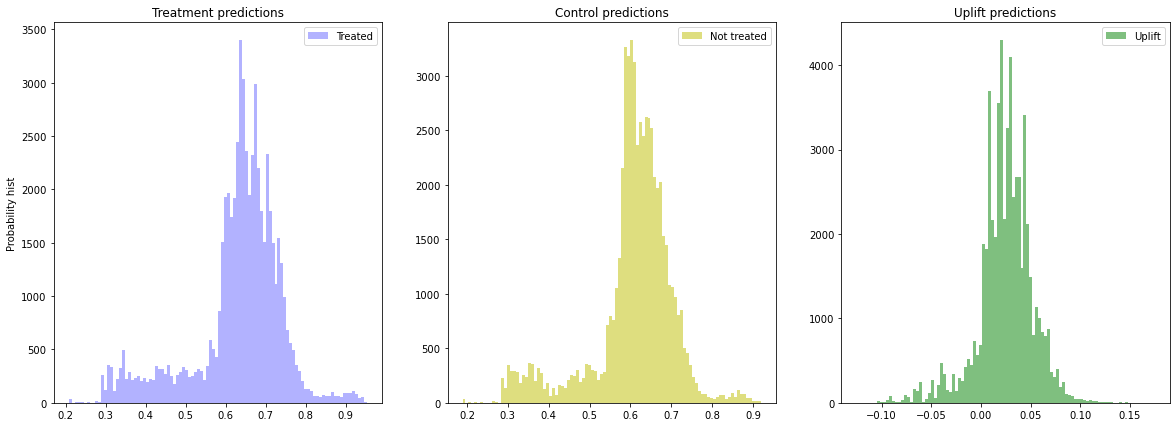

In [32]:
# installation instructions: https://github.com/maks-sh/scikit-uplift
# link to the documentation: https://scikit-uplift.readthedocs.io/en/latest/
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel

# sklift supports all models, 
# that satisfy scikit-learn convention
# for example, let's use catboost
from catboost import CatBoostClassifier

# Solo model - aka Treatment Dummy, aka include treatment as feature in model
sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
sm = sm.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_sm = sm.predict(X_val)

sm_score = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.3)

models_results['approach'].append('SoloModel')
models_results['uplift@30%'].append(sm_score)

# get conditional probabilities (predictions) of performing the target action 
# during interaction for each object
sm_trmnt_preds = sm.trmnt_preds_
# And conditional probabilities (predictions) of performing the target action 
# without interaction for each object
sm_ctrl_preds = sm.ctrl_preds_

# draw the probability (predictions) distributions and their difference (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

### 1.2 Class Transformation

Simple yet powerful and mathematically proven uplift modeling method, presented in 2012.
The main idea is to predict a slightly changed target $Z_i$:

$$
Z_i = Y_i \cdot W_i + (1 - Y_i) \cdot (1 - W_i),
$$

where 

* $Z_i$ - new target variable of the $i$ client; 
* $Y_i$ - target variable of the $i$ client;
* $W_i$ - flag for communication of the $i$ client;  


In other words, the new target equals 1 if a response in the treatment group is as good as a response in the control group and equals 0 otherwise:

$$
Z_i = \begin{cases}
    1, & \mbox{if } W_i = 1 \mbox{ and } Y_i = 1 \\
    1, & \mbox{if } W_i = 0 \mbox{ and } Y_i = 0 \\
    0, & \mbox{otherwise}
   \end{cases}
$$

Let's go deeper and estimate the conditional probability of the target variable:

$$ 
P(Z=1|X = x) = \\
= P(Z=1|X = x, W = 1) \cdot P(W = 1|X = x) + \\
+ P(Z=1|X = x, W = 0) \cdot P(W = 0|X = x) = \\
= P(Y=1|X = x, W = 1) \cdot P(W = 1|X = x) + \\
+ P(Y=0|X = x, W = 0) \cdot P(W = 0|X = x).
$$

We assume that $ W $ is independent of $X = x$ by design.
Thus we have: $P(W | X = x) = P(W)$ and

$$
P(Z=1|X = x) = \\
= P^T(Y=1|X = x) \cdot P(W = 1) + \\
+ P^C(Y=0|X = x) \cdot P(W = 0)
$$

Also, we assume that $P(W = 1) = P(W = 0) = \frac{1}{2}$, which means that during the experiment the control and the treatment groups were divided in equal proportions. Then we get the following:

$$
P(Z=1|X = x) = \\
= P^T(Y=1|X = x) \cdot \frac{1}{2} + P^C(Y=0|X = x) \cdot \frac{1}{2} \Rightarrow \\
2 \cdot P(Z=1|X = x) = \\
= P^T(Y=1|X = x) + P^C(Y=0|X = x) = \\
= P^T(Y=1|X = x) + 1 - P^C(Y=1|X = x) \Rightarrow \\
\Rightarrow P^T(Y=1|X = x) - P^C(Y=1|X = x) = \\
 = uplift = 2 \cdot P(Z=1|X = x) - 1
$$

Thus, by doubling the estimate of the new target $Z$ and subtracting one we will get an estimation of the uplift:

$$
uplift = 2 \cdot P(Z=1) - 1
$$

This approach is based on the assumption: $P(W = 1) = P(W = 0) = \frac{1}{2}$,  That is the reason that it has to be used only in cases where the number of treated customers (communication) is equal to the number of control customers (no communication).

In [36]:
from sklift.models import ClassTransformation


ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_ct = ct.predict(X_val)

ct_score = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.3)

models_results['approach'].append('ClassTransformation')
models_results['uplift@30%'].append(ct_score)




In [37]:
pd.DataFrame(data=models_results).sort_values('uplift@30%', ascending=False)

,approach,uplift@30%
0,SoloModel,0.057262
1,ClassTransformation,0.053981
2,ClassTransformation,0.053981
3,ClassTransformation,0.053981
4,ClassTransformation,0.053981


## 2. Approaches with two models

The two-model approach can be found in almost any uplift modeling work and is often used as a baseline. However, using two models can lead to some unpleasant consequences: if you use fundamentally different models for training, or if the nature of the test and control group data is very different, then the scores returned by the models will not be comparable. As a result, the calculation of the uplift will not be completely correct. To avoid this effect, you need to calibrate the models so that their scores can be interpolated as probabilities. The calibration of model probabilities is described perfectly in [scikit-learn documentation](https://scikit-learn.org/stable/modules/calibration.html).

Two independent models

The main idea is to estimate the conditional probabilities of the treatment and control groups separately.

1. Train the first model using the treatment set.
2. Train the second model using the control set.
3. Inference: subtract the control model scores from the treatment model scores.

<p align= "center">
  <img src="https://raw.githubusercontent.com/maks-sh/scikit-uplift/master/docs/_static/images/TwoModels_vanila.png" alt="Two Models vanila"/>
</p>

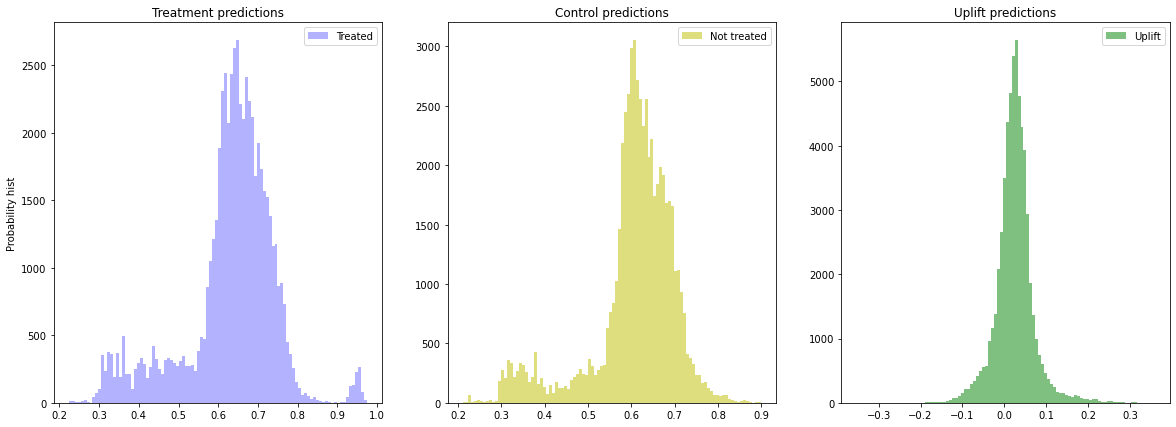

In [38]:
from sklift.models import TwoModels


tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)
tm = tm.fit(
    X_train, y_train, treat_train,
    estimator_trmnt_fit_params={'cat_features': cat_features}, 
    estimator_ctrl_fit_params={'cat_features': cat_features}
)

uplift_tm = tm.predict(X_val)

tm_score = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.3)

models_results['approach'].append('TwoModels')
models_results['uplift@30%'].append(tm_score)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

Bonus - you can also try to first train the $P^T$ classifier, and then use its predictions as a feature for the $P^C$ classifier.

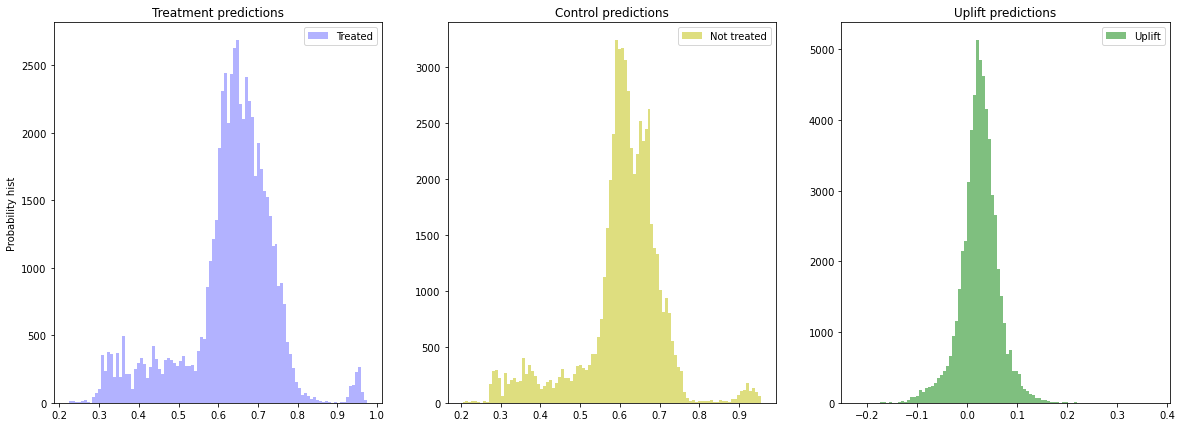

In [39]:
tm_trmnt = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='ddr_treatment'
)
tm_trmnt = tm_trmnt.fit(
    X_train, y_train, treat_train,
    estimator_trmnt_fit_params={'cat_features': cat_features}, 
    estimator_ctrl_fit_params={'cat_features': cat_features}
)

uplift_tm_trmnt = tm_trmnt.predict(X_val)

tm_trmnt_score = uplift_at_k(y_true=y_val, uplift=uplift_tm_trmnt, treatment=treat_val, strategy='by_group', k=0.3)

models_results['approach'].append('TwoModels_ddr_treatment')
models_results['uplift@30%'].append(tm_trmnt_score)

plot_uplift_preds(trmnt_preds=tm_trmnt.trmnt_preds_, ctrl_preds=tm_trmnt.ctrl_preds_);

## Conclusion

Let's consider which method performed best in this task and use it to speed up the test sample:

In [40]:
pd.DataFrame(data=models_results).sort_values('uplift@30%', ascending=False)

,approach,uplift@30%
0,SoloModel,0.057262
1,ClassTransformation,0.053981
2,ClassTransformation,0.053981
3,ClassTransformation,0.053981
4,ClassTransformation,0.053981
5,TwoModels,0.049310
6,TwoModels_ddr_treatment,0.033900


From the table above you can see that the current task suits best for the approach to the transformation of the target line. Let's train the model on the entire sample and predict the test.